# 16/05/2024
Notebook for listening to the attacks etc.

In [1]:
import IPython.display as ipd
import numpy as np

from src.audio_utils import read_audio
from src.utils import *
from sp_utils import spectrogram_inversion, get_spectrogram_from_audio
from attacks_utils import retrieve_single_cached_spec, load_spec_model, evaluate_spec, get_pred_class

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

config_path = '../config/residualnet_train_config.yaml'
config = read_yaml(config_path)

rate = 16000

***
## Testing the audio pipeline
### Original phase available

In [3]:
# index = 5
# file, label, spec = retrieve_single_cached_spec(config, index)
# audio, phase = spectrogram_inversion(config, index, spec, phase_info=True, phase_to_use=None)
# ipd.Audio(audio, rate=rate)

### Original phase not available
SPSI + Griffin_Lim

In [4]:
# file, label, spec = retrieve_single_cached_spec(config, index)
# audio, phase = spectrogram_inversion(config, index, spec, phase_info=False, phase_to_use=None)
# ipd.Audio(audio, rate=rate)

***
## Check the cached spectrograms

In [5]:
import librosa

def plot_cached_spec(index, config):
    file, label, spec = retrieve_single_cached_spec(config, index)
    print(f'The spectrogram is {spec.shape}')
    audio, phase = spectrogram_inversion(config, index=index, spec=spec, phase_info=True, phase_to_use=None)
    print(f'Retrieved {file}, with label {label}')
    plt.figure()
    sr=16000
    librosa.display.specshow(spec, x_axis='time', sr=sr, y_axis='linear')
    plt.colorbar()
    return audio


In [14]:
def plot_spec(spec):
    plt.figure()
    sr=16000
    librosa.display.specshow(spec, x_axis='time', sr=sr, y_axis='linear')
    plt.colorbar()
    plt.show()

Evaluating file /nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_eval/flac/LA_E_8877452.flac with label 1
The spectrogram is (1025, 121)


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/nas/home/wwang/miniconda3/envs/thesis/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/nas/home/wwang/miniconda3/envs/thesis/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/nas/home/wwang/miniconda3/envs/

Reetrieved /nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_eval/flac/LA_E_8877452.flac, with label 1


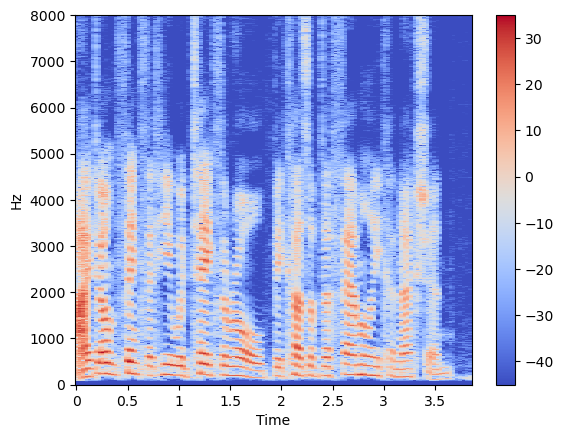

In [6]:
audio= plot_cached_spec(index=1, config=config)

*** 
## Check the audios
Function for getting whatever type of audio file (evaluation or perturbed + the class label and the model prediction in all cases)

In [18]:
def get_audio_file(config, index, attack=False, epsilon=None):
    '''
    Get any audio file, either from the evaluation dataset or from the perturbed audio folders.
    Also check the model prediction on the audio file.
    :param config: path to config file
    :param index: index of audio wrt evaluation list
    :param attack: None, or 'FGSM' 
    :param epsilon: epsilon value if attack is not None
    :return: audio file and its sample rate
    '''
    df_eval = pd.read_csv(os.path.join('..', config["df_eval_path"]))
    file_eval = list(df_eval['path'])
    label_eval = list(df_eval['label'])
    file = file_eval[index]
    label = label_eval[index]
    
    model = load_spec_model(device=device, config=config)
    model.eval()

    if attack:
        split_file = os.path.splitext(os.path.basename(file))[0]
        epsilon_str = str(epsilon).replace('.', 'dot')

        if attack == 'FGSM':
            folder = f'FGSM_data/FGSM_dataset_{epsilon_str}'
        else:
            pass

        p_file = os.path.join(folder, f'{attack}_{split_file}_{epsilon_str}.flac')
        spec = get_spectrogram_from_audio(p_file)
        out = evaluate_spec(spec, model, device)
        print(f'\n{out}')
        pred_class = get_pred_class(out)

        print(f'Got the perturbed AUDIO {p_file}.\nGT label = {label}.\nEspilon = {epsilon}.\nModel prediction is {pred_class}\n')
        X, sr = read_audio(p_file)

    else:
        spec = get_spectrogram_from_audio(file)
        out = evaluate_spec(spec, model, device)
        pred_class = get_pred_class(out)
        print(f'Got the original AUDIO {file}.\nGT label = {label}.\nEpsilon = {epsilon}\nModel prediction is {pred_class}\n')
        X, sr = read_audio(file)

    return X, sr, spec

***
## Check the spectrograms

In [12]:
# def get_spectrograms(config, index, attack=False, epsilon=None):
#     # TODO not yet modified for whole perturbed datasets
#     '''
#     Get the cached spectrogram, either clean or perturbed
#     :param config: path to config file
#     :param index: index of the file wrt evaluation dataset
#     :param attack: None, or 'FGSM' or 'FGSM_1'
#     :param epsilon: epsilon value
#     :return: None
#     '''
#     model = load_spec_model(device=device, config=config)
#     model.eval()
# 
#     if attack:
#         df_eval = pd.read_csv(os.path.join('..', config["df_eval_path"]))
#         file_eval = list(df_eval['path'])
#         label_eval = list(df_eval['label'])
#         file = file_eval[index]
#         label = label_eval[index]
# 
#         split_file = os.path.splitext(os.path.basename(file))[0]
#         epsilon_str = str(epsilon).replace('.', 'dot')
# 
#         if attack == 'FGSM':
#             folder = 'FGSM_data/p_specs'
#         else:
#             pass
# 
#         p_spec_path = os.path.join(folder, f'{attack}_{split_file}_{epsilon_str}.npy')
#         p_spec = np.load(p_spec_path)
#         out = evaluate_spec(p_spec, model, device)
#         print(f'\n{out}')
#         pred_class = get_pred_class(out)
#         print(f'Got the perturbed spectrogram {p_spec_path}.\nGT label = {label}.\nEpsilon = {epsilon}\nModel prediction is {pred_class}')
#         
# 
#     else:
#         file, label, spec = retrieve_single_cached_spec(config, index)
#         out = evaluate_spec(spec, model, device)
#         pred_class = get_pred_class(out)
#         print(f'Got the original spectrogram {file}.\nGT label = {label}.\nEpsilon = {epsilon}\nModel prediction is {pred_class}')
#         
#     


### Check the files

In [31]:
index = 3
epsilon = 2.0

X, sr, spec = get_audio_file(config, index=index, attack=None, epsilon=None)
X_p, sr, p_spec = get_audio_file(config, index=index, attack='FGSM', epsilon=epsilon)

Got the original AUDIO /nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_eval/flac/LA_E_6977360.flac.
GT label = 1.
Epsilon = None
Model prediction is 1


tensor([[-0.0447, -3.1295]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
Got the perturbed AUDIO FGSM_data/FGSM_dataset_2dot0/FGSM_LA_E_6977360_2dot0.flac.
GT label = 1.
Espilon = 2.0.
Model prediction is 0


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fce787625d0>


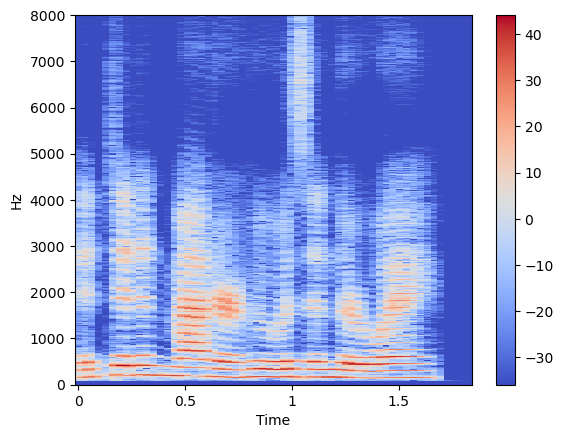

In [32]:
plot_spec(spec)

In [35]:
ipd.Audio(X, rate=rate)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fce7836a4d0>


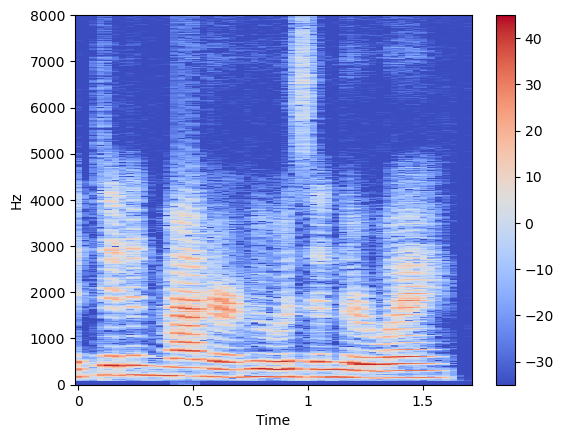

In [34]:
plot_spec(p_spec)

In [36]:
ipd.Audio(X_p, rate=rate)